# Models plots

In [15]:
import sys
from pathlib import Path

import os
from pathlib import Path
NOTEBOOK_DIR = Path(os.getcwd())
ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils.config_resolver import load_config
from src.data.load_data import load_flights          # or loader.py if you named it that way
from src.data.train_test_split import train_test_split_flight
from src.features.add_features import add_features
from src.features.soc_estimation import compute_soc
import joblib
from src.utils.path_resolver import MODELS_DIR


In [17]:
df = load_flights()
df = add_features(df)
df = compute_soc(df)   # adds dt_sec, mAh_used, soc_coulomb_mAh

# 2. Train/test split by flight (same logic as training)
cfg = load_config("mlr.yaml")
split = cfg["train_split"]
features = cfg["features"]

train_df, test_df = train_test_split_flight(df, split_ratio=split)

In [19]:
model_path = MODELS_DIR / "mlr_battery_current.pkl"
mlr_model = joblib.load(model_path)

X_test = test_df[features].fillna(0.0)
test_df = test_df.copy()
test_df["battery_current_pred"] = mlr_model.predict(X_test)

test_ids = test_df["flight"].unique()
flight_to_plot = np.random.choice(test_ids)

C:\Users\muric\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


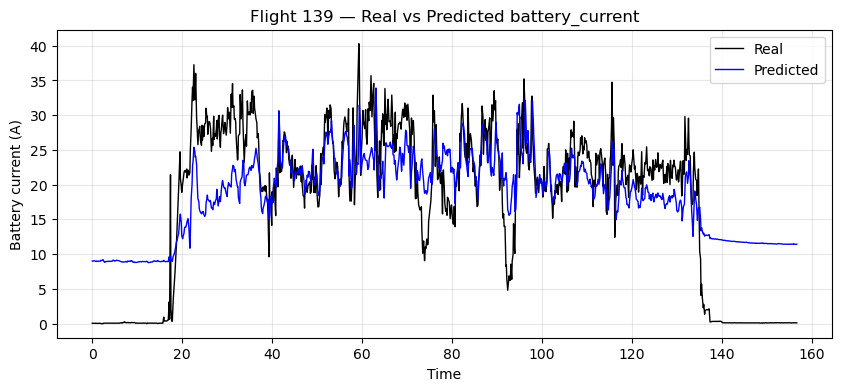

In [21]:
plot_data = (
    test_df[test_df["flight"] == flight_to_plot]
    .sort_values("time")
    .copy()
)

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["battery_current"], label="Real", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["battery_current_pred"], label="Predicted", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted battery_current")
plt.xlabel("Time")
plt.ylabel("Battery current (A)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


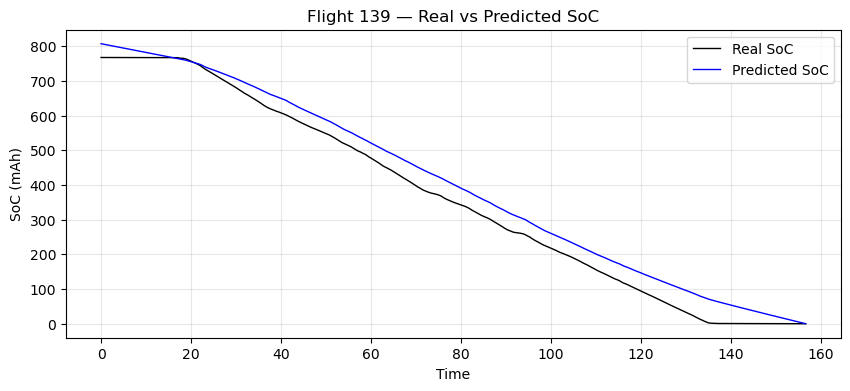

In [23]:
plot_data = plot_data.copy()

# ensure dt_sec for this flight only (numeric time)
# if time is already numeric (seconds) this is fine
plot_data["dt_sec"] = plot_data["time"].diff().fillna(0.0)

# Real current → SoC
plot_data["mAh_used"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current"] * 1000)
plot_data["cum_mAh_used"] = plot_data["mAh_used"].cumsum()
plot_data["total_mAh_used"] = plot_data["cum_mAh_used"].max()
plot_data["soc_coulomb_mAh"] = plot_data["total_mAh_used"] - plot_data["cum_mAh_used"]

# Predicted current → SoC_pred
plot_data["mAh_used_pred"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current_pred"] * 1000)
plot_data["cum_mAh_used_pred"] = plot_data["mAh_used_pred"].cumsum()
plot_data["total_mAh_used_pred"] = plot_data["cum_mAh_used_pred"].max()
plot_data["soc_coulomb_mAh_pred"] = plot_data["total_mAh_used_pred"] - plot_data["cum_mAh_used_pred"]

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh"], label="Real SoC", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh_pred"], label="Predicted SoC", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted SoC")
plt.xlabel("Time")
plt.ylabel("SoC (mAh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
